In [1]:
import numpy as np
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
from mlflow.models.signature import infer_signature

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from yellowbrick.classifier import ROCAUC

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_default = pd.read_csv('../data/processed/dataset_model.csv')
df_default

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%,date,avg_signed_sentiment,count_positive,count_negative,count_neutral,total_tweets
0,2025-07-04,3.67,3.68,3.71,3.65,"91,14M","-0,27%",2025-07-04,-0.000960,4.0,3.0,54.0,61.0
1,2025-07-03,3.68,3.71,3.73,3.68,"119,67M","0,00%",2025-07-03,0.052033,5.0,3.0,21.0,29.0
2,2025-07-02,3.68,3.65,3.70,3.64,"220,27M","-0,54%",2025-07-02,-0.007767,2.0,2.0,16.0,20.0
3,2025-07-01,3.70,3.78,3.79,3.67,"212,37M","-1,07%",2025-07-01,-0.018503,4.0,4.0,16.0,24.0
4,2025-06-30,3.74,3.84,3.84,3.73,"271,93M","-2,35%",2025-06-30,-0.124553,0.0,2.0,12.0,14.0
5,2025-06-26,3.83,3.78,3.83,3.75,"171,43M","1,86%",2025-06-26,0.198789,1.0,0.0,4.0,5.0
6,2025-06-25,3.76,3.83,3.83,3.73,"164,26M","-0,53%",2025-06-25,-0.072154,0.0,1.0,11.0,12.0
7,2025-06-24,3.78,3.82,3.90,3.77,"281,59M","1,61%",2025-06-24,0.000000,0.0,0.0,15.0,15.0
8,2025-06-23,3.72,3.73,3.75,3.66,"222,07M","-1,85%",2025-06-23,-0.374837,0.0,6.0,8.0,14.0
9,2025-06-20,3.79,3.74,3.84,3.74,"516,18M","-0,26%",2025-06-20,-0.111262,2.0,3.0,10.0,15.0


In [3]:
df_default.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Tanggal               39 non-null     object 
 1   Terakhir              39 non-null     float64
 2   Pembukaan             39 non-null     float64
 3   Tertinggi             39 non-null     float64
 4   Terendah              39 non-null     float64
 5   Vol.                  39 non-null     object 
 6   Perubahan%            39 non-null     object 
 7   date                  39 non-null     object 
 8   avg_signed_sentiment  38 non-null     float64
 9   count_positive        38 non-null     float64
 10  count_negative        38 non-null     float64
 11  count_neutral         38 non-null     float64
 12  total_tweets          38 non-null     float64
dtypes: float64(9), object(4)
memory usage: 4.1+ KB


In [4]:
df_default.dropna(inplace=True)

In [5]:
df_default.drop(columns=['date'])

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%,avg_signed_sentiment,count_positive,count_negative,count_neutral,total_tweets
0,2025-07-04,3.67,3.68,3.71,3.65,"91,14M","-0,27%",-0.000960,4.0,3.0,54.0,61.0
1,2025-07-03,3.68,3.71,3.73,3.68,"119,67M","0,00%",0.052033,5.0,3.0,21.0,29.0
2,2025-07-02,3.68,3.65,3.70,3.64,"220,27M","-0,54%",-0.007767,2.0,2.0,16.0,20.0
3,2025-07-01,3.70,3.78,3.79,3.67,"212,37M","-1,07%",-0.018503,4.0,4.0,16.0,24.0
4,2025-06-30,3.74,3.84,3.84,3.73,"271,93M","-2,35%",-0.124553,0.0,2.0,12.0,14.0
5,2025-06-26,3.83,3.78,3.83,3.75,"171,43M","1,86%",0.198789,1.0,0.0,4.0,5.0
6,2025-06-25,3.76,3.83,3.83,3.73,"164,26M","-0,53%",-0.072154,0.0,1.0,11.0,12.0
7,2025-06-24,3.78,3.82,3.90,3.77,"281,59M","1,61%",0.000000,0.0,0.0,15.0,15.0
8,2025-06-23,3.72,3.73,3.75,3.66,"222,07M","-1,85%",-0.374837,0.0,6.0,8.0,14.0
9,2025-06-20,3.79,3.74,3.84,3.74,"516,18M","-0,26%",-0.111262,2.0,3.0,10.0,15.0


In [6]:
df_default['Tanggal'] = pd.to_datetime(df_default['Tanggal'])
df_default.sort_values(by='Tanggal', inplace=True)

In [7]:
def parse_volume(vol_str):
    if isinstance(vol_str, str):
        vol_str = vol_str.replace(',', '.')
        if vol_str.endswith('M'):
            return float(vol_str[:-1]) * 1_000_000
        elif vol_str.endswith('K'):
            return float(vol_str[:-1]) * 1_000
        else:
            return float(vol_str)
    return vol_str

df_default['Vol.'] = df_default['Vol.'].apply(parse_volume)

In [8]:
df_default['Perubahan%'] = df_default['Perubahan%'].str.replace('%', '', regex=False)
df_default['Perubahan%'] = df_default['Perubahan%'].str.replace(',', '.', regex=False).astype(float)

In [9]:
df_default

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%,date,avg_signed_sentiment,count_positive,count_negative,count_neutral,total_tweets
37,2025-05-05,3.86,3.90,3.92,3.86,196920000.0,-0.52,2025-05-05,0.180110,5.0,0.0,21.0,26.0
36,2025-05-06,3.88,3.84,3.90,3.84,111330000.0,0.52,2025-05-06,-0.010816,1.0,1.0,15.0,17.0
35,2025-05-07,3.91,3.90,3.91,3.87,119760000.0,0.77,2025-05-07,-0.220537,0.0,2.0,4.0,6.0
34,2025-05-08,3.79,3.91,3.96,3.78,224120000.0,-3.07,2025-05-08,-0.209798,0.0,3.0,11.0,14.0
33,2025-05-09,3.84,3.81,3.84,3.76,147640000.0,1.32,2025-05-09,0.000000,0.0,0.0,5.0,5.0
32,2025-05-14,4.09,4.00,4.09,3.96,461640000.0,6.51,2025-05-14,-0.085922,1.0,5.0,32.0,38.0
31,2025-05-15,4.27,4.14,4.31,4.13,537150000.0,4.40,2025-05-15,0.075178,18.0,12.0,40.0,70.0
30,2025-05-16,4.25,4.31,4.33,4.16,289340000.0,-0.47,2025-05-16,-0.176841,3.0,7.0,17.0,27.0
29,2025-05-19,4.23,4.23,4.26,4.20,145940000.0,-0.47,2025-05-19,0.331064,10.0,1.0,13.0,24.0
28,2025-05-20,4.21,4.23,4.28,4.17,209580000.0,-0.47,2025-05-20,0.048572,4.0,3.0,10.0,17.0


In [10]:
# Fitur tambahan
df_default['range'] = df_default['Tertinggi'] - df_default['Terendah']
df_default['day_return'] = df_default['Terakhir'].pct_change()
df_default['sentiment_ratio'] = df_default['count_positive'] / (df_default['count_negative'] + 1)
df_default['tweet_intensity'] = df_default['total_tweets'] / (df_default['Vol.'] + 1)

# Lag features (harga hari sebelumnya)
df_default['lag_1'] = df_default['Terakhir'].shift(1)
df_default['lag_2'] = df_default['Terakhir'].shift(2)

# Target: apakah harga besok lebih tinggi dari hari ini?
df_default['target'] = (df_default['Terakhir'].shift(-1) > df_default['Terakhir']).astype(int)

# Tambahkan kolom deskripsi target
df_default['keterangan_target'] = df_default['target'].map({1: 'Naik', 0: 'Turun/Stagnan'})

In [11]:
# Drop baris NaN
df_default = df_default.dropna()

In [12]:
df_all = df_default.copy()

In [13]:
y = df_all['target']

In [14]:
# 🔹 Model dictionary
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "LogReg": LogisticRegression(max_iter=1000),
    "SVC": SVC(probability=True),  # Untuk ROC AUC perlu probabilitas
    "MLP": MLPClassifier(max_iter=1000, random_state=42)
}

# 🔹 Directional accuracy
def directional_accuracy(y_true, y_pred):
    y_true = pd.Series(y_true).reset_index(drop=True)
    y_pred = pd.Series(y_pred).reset_index(drop=True)
    return np.mean(np.sign(y_true.diff().fillna(0)) == np.sign(y_pred.diff().fillna(0)))

# 🔹 Evaluasi model
def evaluate_model(model_or_pipeline, X, y, model_name="Model"):
    tscv = TimeSeriesSplit(n_splits=5)
    metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'directional_acc': []}
    all_conf_matrices = []

    fold = 1
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Buat pipeline
        if isinstance(model_or_pipeline, Pipeline):
            pipeline = model_or_pipeline
        else:
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model_or_pipeline)
            ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # Prediksi probabilitas
        if hasattr(pipeline.named_steps['model'], "predict_proba"):
            y_proba = pipeline.predict_proba(X_test)[:, 1]
        elif hasattr(pipeline.named_steps['model'], "decision_function"):
            y_proba = pipeline.decision_function(X_test)
        else:
            y_proba = None

        if len(np.unique(y_test)) > 1:
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            cm = confusion_matrix(y_test, y_pred)
            da = directional_accuracy(y_test, y_pred)

            # ROC AUC hanya jika valid
            if y_proba is not None and len(np.unique(y_test)) > 1:
                try:
                    roc_auc = roc_auc_score(y_test, y_proba)
                except:
                    roc_auc = 0
            else:
                roc_auc = 0

            metrics['accuracy'].append(acc)
            metrics['precision'].append(prec)
            metrics['recall'].append(rec)
            metrics['f1'].append(f1)
            metrics['roc_auc'].append(roc_auc)
            metrics['directional_acc'].append(da)
            all_conf_matrices.append(cm)

            print(f"\n📊 Fold {fold} Confusion Matrix:")
            print(classification_report(y_test, y_pred, zero_division=0))

            # 🔹 Visualisasi Confusion Matrix
            # plt.figure(figsize=(5, 4))
            # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            # plt.title(f"{model_name} - Fold {fold} Confusion Matrix")
            # plt.xlabel("Predicted")
            # plt.ylabel("Actual")
            # plt.tight_layout()
            # plt.show()

            # 🔹 Visualisasi ROC Curve via Yellowbrick
            # if y_proba is not None and len(np.unique(y_test)) > 1:
            #     visualizer = ROCAUC(pipeline.named_steps['model'], classes=["Neg", "Pos"], binary=True)
            #     visualizer.fit(X_train, y_train)
            #     visualizer.score(X_test, y_test)
            #     visualizer.show()

        else:
            print(f"\n⚠️ Fold {fold}: Only one class present in y_test, skipping metrics.")

        fold += 1

    # Rata-rata dan deviasi
    mean_metrics = {f"{k}_mean": np.mean(v) if v else 0 for k, v in metrics.items()}
    std_metrics = {f"{k}_std": np.std(v) if v else 0 for k, v in metrics.items()}

    # Logging ke MLflow
    with mlflow.start_run(run_name=model_name):
        for k, v in mean_metrics.items():
            mlflow.log_metric(k, v)
        for k, v in std_metrics.items():
            mlflow.log_metric(k, v)

        input_example = X_test.head(1)
        signature = infer_signature(X_test, y_pred)
        mlflow.sklearn.log_model(pipeline, f"{model_name}_model", input_example=input_example, signature=signature)

    return {**mean_metrics, **std_metrics}

In [ ]:
# Tahap 1 - Evaluasi data historis
features_hist = ['Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah', 'Vol.', 'Perubahan%', 'range', 'day_return', 'lag_1', 'lag_2']
X_hist = df_all[features_hist]

print("🔹 Tahap 1: Data Historis")
results_hist = {}

for name, model in models.items():
    print(f"\n🔍 Evaluating {name} with historical data...")
    results_hist[name] = evaluate_model(model, X_hist, y)

🔹 Tahap 1: Data Historis

🔍 Evaluating RandomForest with historical data...

📊 Fold 1 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6


📊 Fold 2 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.60      1.00      0.75         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6


⚠️ Fold 3: Only one class present in y_test, skipping metrics.

📊 Fold 4 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1 

2025/07/21 22:19:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



🔍 Evaluating XGBoost with historical data...

📊 Fold 1 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6


📊 Fold 2 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.25      0.33      0.29         3

    accuracy                           0.17         6
   macro avg       0.12      0.17      0.14         6
weighted avg       0.12      0.17      0.14         6


⚠️ Fold 3: Only one class present in y_test, skipping metrics.

📊 Fold 4 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.50      0.50      0.50

2025/07/21 22:19:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



🔍 Evaluating LogReg with historical data...

📊 Fold 1 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6


📊 Fold 2 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.50      0.67      0.57         3

    accuracy                           0.50         6
   macro avg       0.50      0.50      0.49         6
weighted avg       0.50      0.50      0.49         6


⚠️ Fold 3: Only one class present in y_test, skipping metrics.

📊 Fold 4 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       0.00      0.00      0.00 

2025/07/21 22:19:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



🔍 Evaluating SVC with historical data...

📊 Fold 1 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6


📊 Fold 2 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      1.00      0.67         3

    accuracy                           0.50         6
   macro avg       0.25      0.50      0.33         6
weighted avg       0.25      0.50      0.33         6


⚠️ Fold 3: Only one class present in y_test, skipping metrics.

📊 Fold 4 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.50      1.00      0.67    

2025/07/21 22:19:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



🔍 Evaluating MLP with historical data...

📊 Fold 1 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6


📊 Fold 2 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6


⚠️ Fold 3: Only one class present in y_test, skipping metrics.

📊 Fold 4 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.40      1.00      0.57    

2025/07/21 22:19:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


In [16]:
# Format output sebagai DataFrame
df_historis = pd.DataFrame(results_hist).T
print("\n📈 Rangkuman Evaluasi Model (Tahap Historis):")
df_historis


📈 Rangkuman Evaluasi Model (Tahap Historis):


,accuracy_mean,precision_mean,recall_mean,f1_mean,roc_auc_mean,directional_acc_mean,accuracy_std,precision_std,recall_std,f1_std,roc_auc_std,directional_acc_std
RandomForest,0.500000,0.333333,0.666667,0.440476,0.652778,0.500000,0.136083,0.249444,0.471405,0.319882,0.199343,0.136083
XGBoost,0.388889,0.250000,0.277778,0.261905,0.310185,0.555556,0.207870,0.204124,0.207870,0.204817,0.187142,0.078567
LogReg,0.500000,0.166667,0.222222,0.190476,0.717593,0.500000,0.136083,0.235702,0.314270,0.269374,0.066448,0.000000
SVC,0.500000,0.333333,0.666667,0.444444,0.365741,0.500000,0.136083,0.235702,0.471405,0.314270,0.371353,0.136083
MLP,0.555556,0.383333,0.666667,0.476190,0.555556,0.500000,0.207870,0.306413,0.471405,0.356348,0.218722,0.136083


In [17]:
# Tahap 2 - Evaluasi data gabungan
features_combined = [
    'Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah', 'Vol.', 'Perubahan%',
    'avg_signed_sentiment', 'count_positive', 'count_negative', 'count_neutral', 'total_tweets',
    'range', 'day_return', 'sentiment_ratio', 'tweet_intensity',
    'lag_1', 'lag_2'
]
X_combined = df_all[features_combined]

print("🔹 Tahap 2: Data Gabungan")
results_combined = {}

for name, model in models.items():
    print(f"\n🔍 Evaluating {name} with combined data...")
    results_combined[name] = evaluate_model(model, X_combined, y)

🔹 Tahap 2: Data Gabungan

🔍 Evaluating RandomForest with combined data...

📊 Fold 1 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6


📊 Fold 2 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6


⚠️ Fold 3: Only one class present in y_test, skipping metrics.

📊 Fold 4 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1   

2025/07/21 22:19:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



🔍 Evaluating XGBoost with combined data...

📊 Fold 1 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6


📊 Fold 2 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6


⚠️ Fold 3: Only one class present in y_test, skipping metrics.

📊 Fold 4 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.67      1.00      0.80  

2025/07/21 22:19:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



🔍 Evaluating LogReg with combined data...

📊 Fold 1 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6


📊 Fold 2 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6


⚠️ Fold 3: Only one class present in y_test, skipping metrics.

📊 Fold 4 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.50      0.50      0.50   

2025/07/21 22:19:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



🔍 Evaluating SVC with combined data...

📊 Fold 1 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6


📊 Fold 2 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      1.00      0.67         3

    accuracy                           0.50         6
   macro avg       0.25      0.50      0.33         6
weighted avg       0.25      0.50      0.33         6


⚠️ Fold 3: Only one class present in y_test, skipping metrics.

📊 Fold 4 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.00      0.00      0.00      

2025/07/21 22:19:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



🔍 Evaluating MLP with combined data...

📊 Fold 1 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6


📊 Fold 2 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6


⚠️ Fold 3: Only one class present in y_test, skipping metrics.

📊 Fold 4 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.33      0.50      0.40      

2025/07/21 22:19:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


In [18]:
df_combined = pd.DataFrame(results_combined).T
print("\n📈 Rangkuman Evaluasi Model (Tahap Gabungan):")
df_combined


📈 Rangkuman Evaluasi Model (Tahap Gabungan):


,accuracy_mean,precision_mean,recall_mean,f1_mean,roc_auc_mean,directional_acc_mean,accuracy_std,precision_std,recall_std,f1_std,roc_auc_std,directional_acc_std
RandomForest,0.611111,0.416667,0.666667,0.507937,0.833333,0.500000,0.207870,0.311805,0.471405,0.367487,0.117851,0.136083
XGBoost,0.666667,0.472222,0.666667,0.552381,0.675926,0.611111,0.235702,0.335640,0.471405,0.391288,0.124914,0.078567
LogReg,0.611111,0.416667,0.500000,0.452381,0.796296,0.555556,0.207870,0.311805,0.408248,0.351543,0.214367,0.078567
SVC,0.444444,0.166667,0.333333,0.222222,0.583333,0.555556,0.078567,0.235702,0.471405,0.314270,0.424918,0.078567
MLP,0.555556,0.361111,0.500000,0.419048,0.750000,0.500000,0.207870,0.306816,0.408248,0.350186,0.270031,0.136083


In [19]:
def optimize_model(model, param_grid, X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    grid = GridSearchCV(pipeline, param_grid=param_grid, cv=tscv, scoring='f1', n_jobs=-1)
    grid.fit(X, y)
    return grid.best_estimator_, grid.best_params_

In [20]:
print("\n🔹 Tahap 3: Optimasi Model")

optimized_models = {}
optimized_folds = [3, 5]


🔹 Tahap 3: Optimasi Model


In [21]:
# Random Forest

rf_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
}

optimized_models['RandomForest'] = {}  # Buat dict nested untuk tiap fold

for n_fold in optimized_folds:
    print(f"\n🔹 Optimasi Random Forest dengan {n_fold}-fold TimeSeriesSplit")
    best_rf, best_rf_params = optimize_model(
        RandomForestClassifier(random_state=42),
        rf_grid,
        X_combined, y,
        n_splits=n_fold  # pastikan fungsi optimize_model menerima ini
    )
    print(f"✅ Best Params ({n_fold} fold):", best_rf_params)

    # Simpan berdasarkan jumlah fold
    optimized_models['RandomForest'][f'{n_fold}_fold'] = {
        'model': best_rf,
        'params': best_rf_params
    }


🔹 Optimasi Random Forest dengan 3-fold TimeSeriesSplit
✅ Best Params (3 fold): {'model__max_depth': None, 'model__n_estimators': 200}

🔹 Optimasi Random Forest dengan 5-fold TimeSeriesSplit
✅ Best Params (5 fold): {'model__max_depth': None, 'model__n_estimators': 100}


In [22]:
# XGBoost

xgb_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 6],
    'model__learning_rate': [0.05, 0.1]
}

optimized_models['XGBoost'] = {}  # Buat dict nested untuk tiap fold

for n_fold in optimized_folds:
    print(f"\n🔹 Optimasi XGBoost dengan {n_fold}-fold TimeSeriesSplit")
    best_xgb, best_xgb_params = optimize_model(
        XGBClassifier(eval_metric='logloss'),
        xgb_grid,
        X_combined, y,
        n_splits=n_fold  # pastikan fungsi optimize_model menerima ini
    )
    print(f"✅ Best Params ({n_fold} fold):", best_xgb_params)

    # Simpan berdasarkan jumlah fold
    optimized_models['XGBoost'][f'{n_fold}_fold'] = {
        'model': best_xgb,
        'params': best_xgb_params
    }


🔹 Optimasi XGBoost dengan 3-fold TimeSeriesSplit
✅ Best Params (3 fold): {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}

🔹 Optimasi XGBoost dengan 5-fold TimeSeriesSplit
✅ Best Params (5 fold): {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}


In [23]:
# LogReg

logreg_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs']
}

optimized_models['LogReg'] = {}  # Buat dict nested untuk tiap fold

for n_fold in optimized_folds:
    print(f"\n🔹 Optimasi LogReg dengan {n_fold}-fold TimeSeriesSplit")
    best_logreg, best_logreg_params = optimize_model(
        LogisticRegression(max_iter=1000),
        logreg_grid,
        X_combined, y,
        n_splits=n_fold  # pastikan fungsi optimize_model menerima ini
    )
    print(f"✅ Best Params ({n_fold} fold):", best_logreg_params)

    # Simpan berdasarkan jumlah fold
    optimized_models['LogReg'][f'{n_fold}_fold'] = {
        'model': best_logreg,
        'params': best_logreg_params
    }


🔹 Optimasi LogReg dengan 3-fold TimeSeriesSplit
✅ Best Params (3 fold): {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

🔹 Optimasi LogReg dengan 5-fold TimeSeriesSplit
✅ Best Params (5 fold): {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


In [24]:
# SVC

svc_grid = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale', 'auto']
}

optimized_models['SVC'] = {}  # Buat dict nested untuk tiap fold

for n_fold in optimized_folds:
    print(f"\n🔹 Optimasi SVC dengan {n_fold}-fold TimeSeriesSplit")
    best_svc, best_svc_params = optimize_model(
        SVC(),
        svc_grid,
        X_combined, y,
        n_splits=n_fold  # pastikan fungsi optimize_model menerima ini
    )
    print(f"✅ Best Params ({n_fold} fold):", best_svc_params)

    # Simpan berdasarkan jumlah fold
    optimized_models['SVC'][f'{n_fold}_fold'] = {
        'model': best_svc,
        'params': best_svc_params
    }


🔹 Optimasi SVC dengan 3-fold TimeSeriesSplit
✅ Best Params (3 fold): {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}

🔹 Optimasi SVC dengan 5-fold TimeSeriesSplit
✅ Best Params (5 fold): {'model__C': 10, 'model__gamma': 'scale', 'model__kernel': 'rbf'}


In [25]:
# MLP

mlp_grid = {
    'model__hidden_layer_sizes': [(100,), (50, 50)],
    'model__activation': ['relu', 'tanh'],
    'model__alpha': [0.0001, 0.001]
}

optimized_models['MLP'] = {}  # Buat dict nested untuk tiap fold

for n_fold in optimized_folds:
    print(f"\n🔹 Optimasi mlp dengan {n_fold}-fold TimeSeriesSplit")
    best_mlp, best_mlp_params = optimize_model(
        MLPClassifier(max_iter=1000, random_state=42),
        mlp_grid,
        X_combined, y,
        n_splits=n_fold  # pastikan fungsi optimize_model menerima ini
    )
    print(f"✅ Best Params ({n_fold} fold):", best_mlp_params)

    # Simpan berdasarkan jumlah fold
    optimized_models['MLP'][f'{n_fold}_fold'] = {
        'model': best_mlp,
        'params': best_mlp_params
    }


🔹 Optimasi mlp dengan 3-fold TimeSeriesSplit
✅ Best Params (3 fold): {'model__activation': 'tanh', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': (100,)}

🔹 Optimasi mlp dengan 5-fold TimeSeriesSplit
✅ Best Params (5 fold): {'model__activation': 'relu', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': (50, 50)}


In [26]:
print("\n📈 Evaluasi Ulang Setelah Optimasi")
results_optimized = {}
for name, folds_dict in optimized_models.items():
    for fold_name, content in folds_dict.items():
        model = content['model']
        key = f"{name}_{fold_name}"
        results_optimized[key] = evaluate_model(model, X_combined, y, model_name=key)


📈 Evaluasi Ulang Setelah Optimasi

📊 Fold 1 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6


📊 Fold 2 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6


⚠️ Fold 3: Only one class present in y_test, skipping metrics.

📊 Fold 4 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.50      1.00      0.67         2


2025/07/21 22:19:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



📊 Fold 1 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6


📊 Fold 2 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6


⚠️ Fold 3: Only one class present in y_test, skipping metrics.

📊 Fold 4 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.50      1.00      0.67         2

    accuracy                      

2025/07/21 22:20:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



📊 Fold 1 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6


📊 Fold 2 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6


⚠️ Fold 3: Only one class present in y_test, skipping metrics.

📊 Fold 4 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.40      1.00      0.57         2

    accuracy                      

2025/07/21 22:20:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



📊 Fold 1 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6


📊 Fold 2 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6


⚠️ Fold 3: Only one class present in y_test, skipping metrics.

📊 Fold 4 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.67      1.00      0.80         2

    accuracy                      

2025/07/21 22:20:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



📊 Fold 1 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6


📊 Fold 2 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6


⚠️ Fold 3: Only one class present in y_test, skipping metrics.

📊 Fold 4 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.00      0.00      0.00         2

    accuracy                      

2025/07/21 22:20:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



📊 Fold 1 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6


📊 Fold 2 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6


⚠️ Fold 3: Only one class present in y_test, skipping metrics.

📊 Fold 4 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.50      0.50      0.50         2

    accuracy                      

2025/07/21 22:20:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



📊 Fold 1 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6


📊 Fold 2 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


⚠️ Fold 3: Only one class present in y_test, skipping metrics.

📊 Fold 4 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.50      1.00      0.67         2

    accuracy                      

2025/07/21 22:20:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



📊 Fold 1 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6


📊 Fold 2 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


⚠️ Fold 3: Only one class present in y_test, skipping metrics.

📊 Fold 4 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.50      1.00      0.67         2

    accuracy                      

2025/07/21 22:20:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



📊 Fold 1 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6


📊 Fold 2 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6


⚠️ Fold 3: Only one class present in y_test, skipping metrics.

📊 Fold 4 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.50      0.50      0.50         2

    accuracy                      

2025/07/21 22:20:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



📊 Fold 1 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6


📊 Fold 2 Confusion Matrix:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6


⚠️ Fold 3: Only one class present in y_test, skipping metrics.

📊 Fold 4 Confusion Matrix:
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.33      0.50      0.40         2

    accuracy                      

2025/07/21 22:20:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


In [27]:
df_optimized = pd.DataFrame(results_optimized).T
print("\n📈 Rangkuman Evaluasi Model (Tahap Optimasi):")
df_optimized


📈 Rangkuman Evaluasi Model (Tahap Optimasi):


,accuracy_mean,precision_mean,recall_mean,f1_mean,roc_auc_mean,directional_acc_mean,accuracy_std,precision_std,recall_std,f1_std,roc_auc_std,directional_acc_std
RandomForest_3_fold,0.611111,0.416667,0.666667,0.507937,0.895833,0.500000,0.207870,0.311805,0.471405,0.367487,0.106230,0.136083
RandomForest_5_fold,0.611111,0.416667,0.666667,0.507937,0.833333,0.500000,0.207870,0.311805,0.471405,0.367487,0.117851,0.136083
XGBoost_3_fold,0.555556,0.383333,0.666667,0.476190,0.833333,0.500000,0.207870,0.306413,0.471405,0.356348,0.235702,0.136083
XGBoost_5_fold,0.666667,0.472222,0.666667,0.552381,0.675926,0.611111,0.235702,0.335640,0.471405,0.391288,0.124914,0.078567
LogReg_3_fold,0.555556,0.250000,0.333333,0.285714,0.800926,0.555556,0.207870,0.353553,0.471405,0.404061,0.153966,0.078567
LogReg_5_fold,0.611111,0.416667,0.500000,0.452381,0.796296,0.555556,0.207870,0.311805,0.408248,0.351543,0.214367,0.078567
SVC_3_fold,0.666667,0.500000,0.666667,0.555556,0.583333,0.611111,0.272166,0.408248,0.471405,0.415740,0.424918,0.283279
SVC_5_fold,0.666667,0.500000,0.666667,0.555556,0.583333,0.611111,0.272166,0.408248,0.471405,0.415740,0.424918,0.283279
MLP_3_fold,0.611111,0.416667,0.500000,0.452381,0.791667,0.555556,0.207870,0.311805,0.408248,0.351543,0.155902,0.078567
MLP_5_fold,0.611111,0.444444,0.500000,0.466667,0.791667,0.611111,0.283279,0.415740,0.408248,0.410961,0.294628,0.283279


In [28]:
df_optimized_pro = df_optimized.copy()

df_optimized_pro = df_optimized_pro.reset_index()
df_optimized_pro.rename(columns={'index': 'model_name'}, inplace=True)

# Ekstrak nama algoritma: RandomForest, XGBoost, LogReg, SVC, MLP
df_optimized_pro['model'] = df_optimized_pro['model_name'].str.extract(r'^([A-Za-z]+)')

# Pastikan kolom f1_mean bertipe float (hindari NaN/string)
df_optimized_pro['f1_mean'] = pd.to_numeric(df_optimized_pro['f1_mean'], errors='coerce')

# Ambil model terbaik (berdasarkan f1 tertinggi) untuk setiap algoritma
best_models = df_optimized_pro.loc[df_optimized_pro.groupby('model')['f1_mean'].idxmax()]
best_models

,model_name,accuracy_mean,precision_mean,recall_mean,f1_mean,roc_auc_mean,directional_acc_mean,accuracy_std,precision_std,recall_std,f1_std,roc_auc_std,directional_acc_std,model
5,LogReg_5_fold,0.611111,0.416667,0.500000,0.452381,0.796296,0.555556,0.207870,0.311805,0.408248,0.351543,0.214367,0.078567,LogReg
9,MLP_5_fold,0.611111,0.444444,0.500000,0.466667,0.791667,0.611111,0.283279,0.415740,0.408248,0.410961,0.294628,0.283279,MLP
0,RandomForest_3_fold,0.611111,0.416667,0.666667,0.507937,0.895833,0.500000,0.207870,0.311805,0.471405,0.367487,0.106230,0.136083,RandomForest
6,SVC_3_fold,0.666667,0.500000,0.666667,0.555556,0.583333,0.611111,0.272166,0.408248,0.471405,0.415740,0.424918,0.283279,SVC
3,XGBoost_5_fold,0.666667,0.472222,0.666667,0.552381,0.675926,0.611111,0.235702,0.335640,0.471405,0.391288,0.124914,0.078567,XGBoost


In [29]:
df_historis_pro = df_historis.copy()

df_historis_pro = df_historis_pro.reset_index()
df_historis_pro.rename(columns={'index': 'model'}, inplace=True)

# Ekstrak nama algoritma: RandomForest, XGBoost, LogReg, SVC, MLP
df_historis_pro['model'] = df_historis_pro['model'].str.extract(r'^([A-Za-z]+)')
df_historis_pro

,model,accuracy_mean,precision_mean,recall_mean,f1_mean,roc_auc_mean,directional_acc_mean,accuracy_std,precision_std,recall_std,f1_std,roc_auc_std,directional_acc_std
0,RandomForest,0.500000,0.333333,0.666667,0.440476,0.652778,0.500000,0.136083,0.249444,0.471405,0.319882,0.199343,0.136083
1,XGBoost,0.388889,0.250000,0.277778,0.261905,0.310185,0.555556,0.207870,0.204124,0.207870,0.204817,0.187142,0.078567
2,LogReg,0.500000,0.166667,0.222222,0.190476,0.717593,0.500000,0.136083,0.235702,0.314270,0.269374,0.066448,0.000000
3,SVC,0.500000,0.333333,0.666667,0.444444,0.365741,0.500000,0.136083,0.235702,0.471405,0.314270,0.371353,0.136083
4,MLP,0.555556,0.383333,0.666667,0.476190,0.555556,0.500000,0.207870,0.306413,0.471405,0.356348,0.218722,0.136083


In [30]:
df_combined_pro = df_combined.copy()

df_combined_pro = df_combined_pro.reset_index()
df_combined_pro.rename(columns={'index': 'model'}, inplace=True)

# Ekstrak nama algoritma: RandomForest, XGBoost, LogReg, SVC, MLP
df_combined_pro['model'] = df_combined_pro['model'].str.extract(r'^([A-Za-z]+)')
df_combined_pro

,model,accuracy_mean,precision_mean,recall_mean,f1_mean,roc_auc_mean,directional_acc_mean,accuracy_std,precision_std,recall_std,f1_std,roc_auc_std,directional_acc_std
0,RandomForest,0.611111,0.416667,0.666667,0.507937,0.833333,0.500000,0.207870,0.311805,0.471405,0.367487,0.117851,0.136083
1,XGBoost,0.666667,0.472222,0.666667,0.552381,0.675926,0.611111,0.235702,0.335640,0.471405,0.391288,0.124914,0.078567
2,LogReg,0.611111,0.416667,0.500000,0.452381,0.796296,0.555556,0.207870,0.311805,0.408248,0.351543,0.214367,0.078567
3,SVC,0.444444,0.166667,0.333333,0.222222,0.583333,0.555556,0.078567,0.235702,0.471405,0.314270,0.424918,0.078567
4,MLP,0.555556,0.361111,0.500000,0.419048,0.750000,0.500000,0.207870,0.306816,0.408248,0.350186,0.270031,0.136083


In [38]:
# Tambahkan kolom untuk penanda dataframe (eksperimen)
df_historis_pro['source'] = 'Model Historis'
df_combined_pro['source'] = 'Model Gabungan'
best_models['source'] = 'Model Optimasi'

# Gabungkan semua dataframe
df_all = pd.concat([df_historis_pro, df_combined_pro, best_models], ignore_index=True)

order = ['Model Historis', 'Model Gabungan', 'Model Optimasi']
df_all['source'] = pd.Categorical(df_all['source'], categories=order, ordered=True)

In [39]:
df_all

,model,accuracy_mean,precision_mean,recall_mean,f1_mean,roc_auc_mean,directional_acc_mean,accuracy_std,precision_std,recall_std,f1_std,roc_auc_std,directional_acc_std,source,model_name
0,RandomForest,0.500000,0.333333,0.666667,0.440476,0.652778,0.500000,0.136083,0.249444,0.471405,0.319882,0.199343,0.136083,Model Historis,NaN
1,XGBoost,0.388889,0.250000,0.277778,0.261905,0.310185,0.555556,0.207870,0.204124,0.207870,0.204817,0.187142,0.078567,Model Historis,NaN
2,LogReg,0.500000,0.166667,0.222222,0.190476,0.717593,0.500000,0.136083,0.235702,0.314270,0.269374,0.066448,0.000000,Model Historis,NaN
3,SVC,0.500000,0.333333,0.666667,0.444444,0.365741,0.500000,0.136083,0.235702,0.471405,0.314270,0.371353,0.136083,Model Historis,NaN
4,MLP,0.555556,0.383333,0.666667,0.476190,0.555556,0.500000,0.207870,0.306413,0.471405,0.356348,0.218722,0.136083,Model Historis,NaN
5,RandomForest,0.611111,0.416667,0.666667,0.507937,0.833333,0.500000,0.207870,0.311805,0.471405,0.367487,0.117851,0.136083,Model Gabungan,NaN
6,XGBoost,0.666667,0.472222,0.666667,0.552381,0.675926,0.611111,0.235702,0.335640,0.471405,0.391288,0.124914,0.078567,Model Gabungan,NaN
7,LogReg,0.611111,0.416667,0.500000,0.452381,0.796296,0.555556,0.207870,0.311805,0.408248,0.351543,0.214367,0.078567,Model Gabungan,NaN
8,SVC,0.444444,0.166667,0.333333,0.222222,0.583333,0.555556,0.078567,0.235702,0.471405,0.314270,0.424918,0.078567,Model Gabungan,NaN
9,MLP,0.555556,0.361111,0.500000,0.419048,0.750000,0.500000,0.207870,0.306816,0.408248,0.350186,0.270031,0.136083,Model Gabungan,NaN


In [40]:
# Korelasi Pearson antara F1 mean dan std
correlation = df_all['f1_mean'].corr(df_all['f1_std'], method='pearson')

print(f"Korelasi antara F1 mean dan F1 std: {correlation:.2f}")

Korelasi antara F1 mean dan F1 std: 0.82


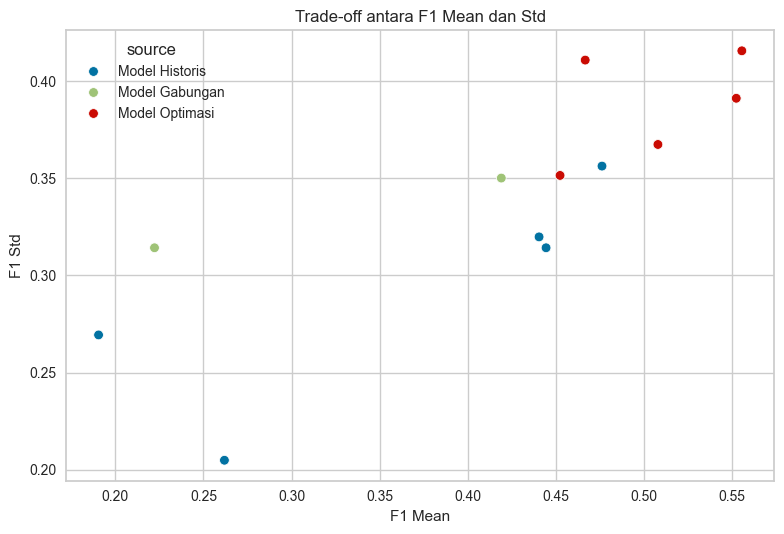

In [41]:
sns.scatterplot(data=df_all, x='f1_mean', y='f1_std', hue='source')
plt.title("Trade-off antara F1 Mean dan Std")
plt.xlabel("F1 Mean")
plt.ylabel("F1 Std")
plt.grid(True)
plt.tight_layout()
plt.show()

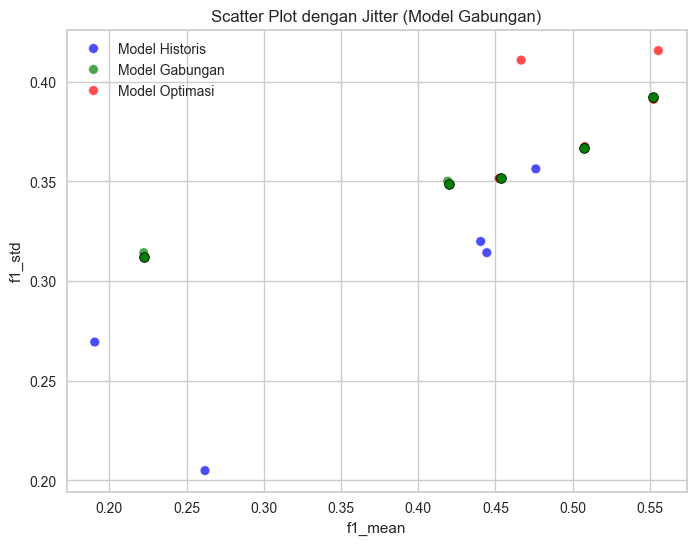

In [42]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_all,
    x="f1_mean",
    y="f1_std",
    hue="source",
    palette={"Model Historis": "blue", "Model Gabungan": "green", "Model Optimasi": "red"},
    alpha=0.7
)

# Tambahkan jitter kecil secara manual jika perlu
df_jittered = df_all.copy()
df_jittered['f1_mean'] += np.random.normal(0, 0.001, size=len(df_all))  # jitter di mean
df_jittered['f1_std'] += np.random.normal(0, 0.001, size=len(df_all))   # jitter di std

sns.scatterplot(
    data=df_jittered[df_jittered['source'] == 'Model Gabungan'],
    x="f1_mean",
    y="f1_std",
    color="green",
    marker='o',
    edgecolor='black'
)
plt.title("Scatter Plot dengan Jitter (Model Gabungan)")
plt.show()

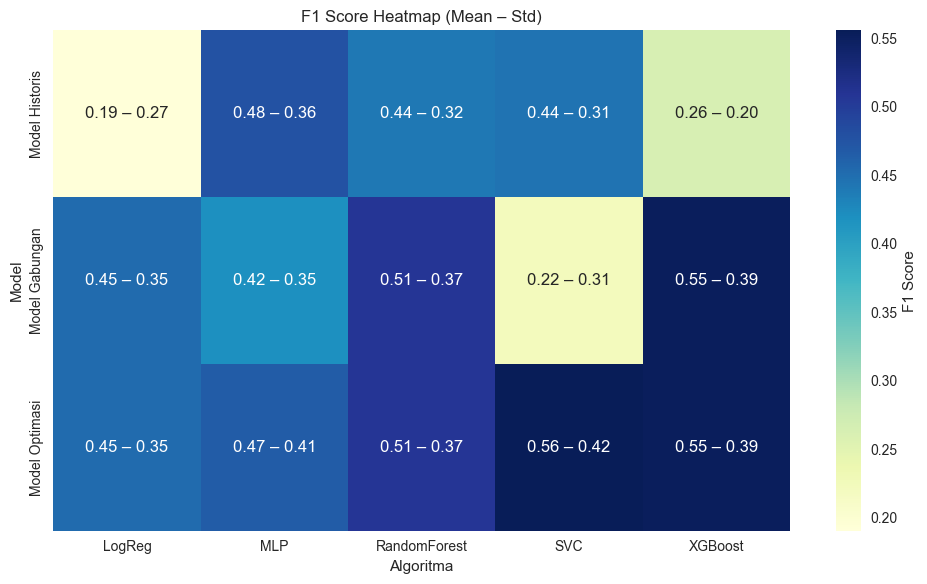

In [43]:
# Gabungkan mean dan std sebagai string anotasi
df_all['f1_label'] = df_all.apply(lambda x: f"{x['f1_mean']:.2f} – {x['f1_std']:.2f}", axis=1)

# Pivot untuk heatmap dengan anotasi gabungan
pivot_val = df_all.pivot(index='source', columns='model', values='f1_mean')
pivot_label = df_all.pivot(index='source', columns='model', values='f1_label')

# Visualisasi heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_val, annot=pivot_label, cmap='YlGnBu', fmt="", cbar_kws={'label': 'F1 Score'})
plt.title("F1 Score Heatmap (Mean – Std)")
plt.xlabel("Algoritma")
plt.ylabel("Model")
plt.tight_layout()
plt.show()